In [214]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline


class IDT:
    """
    Describes IDT with delta-function model.
    """
    e0 = 8.85e-12
    materials_const = {
        'Y-Z_niobate': {
            'v': 3488,
            'dvv': 0.024,
            'einf_e0': 46,
            'TCD': 94
        },
        '128_Y-X_niobate': {
            'v': 3979,
            'dvv': 0.027,
            'einf_e0': 56,
            'TCD': 75
        }

    }
    def __init__(self, p: float = 10e-6,
                 Np: int = 100,
                 material: str='Y-Z_niobate',
                 apodisation: str = 'sinc',
                 aperture: int = 100):
        """

        :param p: pitch is the distance between electrodes
        :param Np: quantity of electrodes
        :param apodisation: apodisation type
        """
        self.p = p
        self.Np = Np
        self.material = material
        self.apodisation = apodisation


        self.v = self.__class__.materials_const[material]['v']
        self.dvv = self.__class__.materials_const[material]['dvv']
        self.einf = self.__class__.materials_const[material]['einf_e0'] * self.__class__.e0
        self.TCD = self.__class__.materials_const[material]['TCD']

        self.lam = 2 * self.p
        self.f_0 = self.v / (2 * self.p)
        self.freq = np.arange(0.1*self.f_0, 2.5*self.f_0, 0.05e6)
        self.Ew = 1.694j * self.dvv
        self.W = aperture * self.lam #апертура, задаётся в длинах волн

        
        self.Kw = np.array([(4 if apodisation else 2)*np.pi*f/self.v for f in self.freq]) # Вектор волновых чисел для каждой частоты
        self.X = np.array([x*self.p for x in range(self.Np)]) # Координаты точечных излучателей
        
        if apodisation:
            dt = 0.5 * self.lam / self.v #2p это лямда, см. теорема Найквиста-Котельникова, т. Отсчётов
            ZM = np.arange(0, self.Np) * self.v * dt
            self.ZM = ZM

            x0 = self.p * self.Np / 2
            XM = 2 * np.pi * (0.07*self.f_0) * (ZM-x0) / self.v

            Wm = np.array([self.W*np.sinc(x/np.pi) for x in XM])

            self.Pm = Wm / self.W
        else:
            self.Pm = np.array([x%2 for x in range(self.Np)]) # Вектор полярностей

        self.A = np.sum(np.array([self.Pm * np.exp(- self.X * self.Kw[i] * 1j ) for i in range(len(self.Kw))]), axis=1) # вектор array факторов

        self.H = - 1j * self.Ew * self.A * np.sqrt( self.freq * self.W * self.einf / self.dvv )

In [215]:
class Filter:

    def __init__(self, idt_1: IDT, idt_2: IDT,
                 d: float = 10e-3,):

        self.Y21 = idt_1.H * idt_2.H * np.exp(-1j * idt_1.Kw * d )
        self.Y12 = self.Y21

        self.Ga = np.abs(idt_2.H ** 2)

        self.Ba = -(scipy.signal.hilbert(self.Ga)).imag

        self.Ct = idt_2.W*idt_2.einf*idt_2.Np

        self.Y11 = self.Ga + 1j*self.Ba + 1j* 2* np.pi * idt_2.freq * self.Ct
        self.Y22 = self.Y11

    def s_from_y(self):
        Z0 = 50
        Y11, Y12, Y21, Y22 = self.Y11, self.Y12, self.Y21, self.Y22

        delta = (1 + Z0 * Y11) * (1 + Z0 * Y22) - Z0 ** 2 * Y12 * Y21
        S11 = ((1 - Z0 * Y11) * (1 + Z0 * Y22) + Z0 ** 2 * Y12 * Y21) / delta
        S12 = (-2 * Z0 * Y12) / delta
        S21 = (-2 * Z0 * Y21) / delta
        S22 = ((1 + Z0 * Y11) * (1 - Z0 * Y22) + Z0 ** 2 * Y12 * Y21) / delta

        return S11, S12, S21, S22

In [224]:
a = IDT(p=10e-6, Np=200, apodisation=True)
b = IDT(p=10e-6, Np=35)


c = Filter(a, b, d=10e-3)

174.4


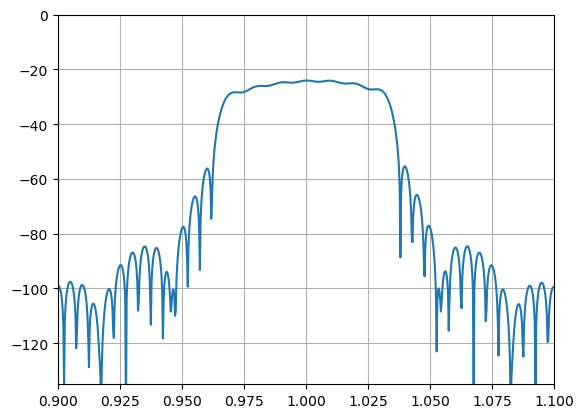

In [225]:
print(a.f_0 * 1e-6)

S = c.s_from_y()

fig, ax = plt.subplots()

ax.plot(a.freq/a.f_0, 20 * np.log10(abs(S[2])))
ax.set_ylim(-135, 0)
ax.set_xlim(0.9, 1.1)
ax.grid()

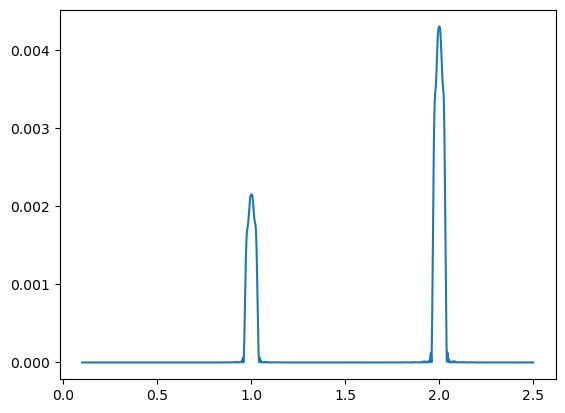

In [161]:
plt.plot(a.freq/a.f_0, np.abs(c.Y21))

<StemContainer object of 3 artists>

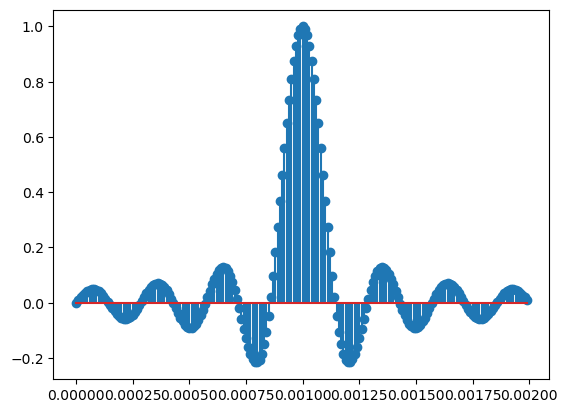

In [181]:
plt.stem(a.ZM, a.Pm)

C:\Users\Pavel\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


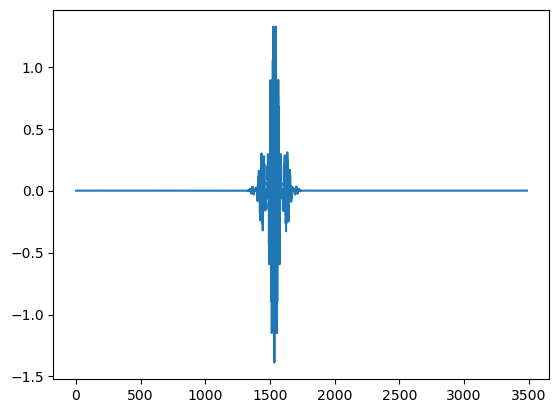

In [163]:

fig, ax = plt.subplots()

fourier = np.fft.fft(H**2,
                       )
ax.plot(np.fft.fftshift(fourier))
#ax.set_xlim(1000, 2000)

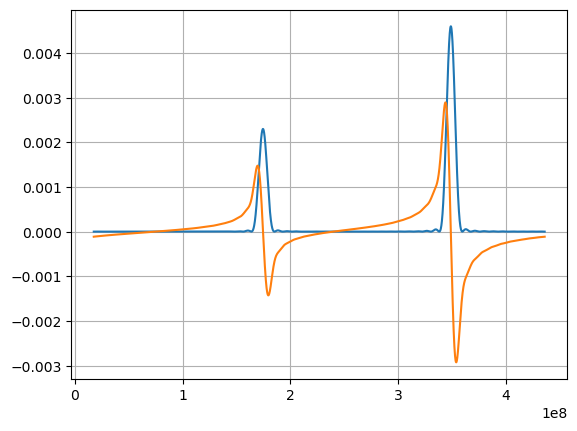

In [164]:
import scipy

Ga = np.abs(b.H**2)

Ba = -(scipy.signal.hilbert(Ga)).imag

fig, axs = plt.subplots()
axs.plot(b.freq, Ga, b.freq, Ba)
axs.grid()

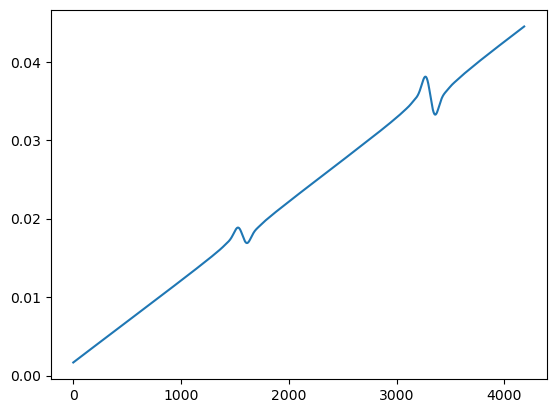

In [165]:
plt.plot(c.Y11.imag)